### Import modules and verify they work? 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr
from tqdm import tqdm
import glob
from devtools import pprint
from tqdm import tqdm

In [2]:
# general eWC
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

Download plugin model

In [3]:
# pip install ewatercycle-lorenz

#### set up paths

In [4]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing')

#### add parameter info

In [5]:
experiment_start_date = "1997-10-01T00:00:00Z"
experiment_end_date = "1997-10-06T00:00:00Z"

In [7]:
from ewatercycle.forcing import sources

In [8]:
lorenz_forcing = sources.LorenzForcing(start_time = experiment_start_date,
                                      end_time = experiment_end_date,
                                      directory = forcing_path,
                                      F = 8,
                                      dt=1e-3
                          )

#### import model

In [9]:
# from ewatercycle.models import Lorenz

#### import DA function:

In [13]:
from ewatercycle_DA import DA

In [14]:
n_particles = 50

In [15]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [16]:
J = 5
common_state = np.zeros(J)
common_state[1] = 0.01

### petrub state every so slightly to start with:

In [17]:
rng = np.random.default_rng()
def add_normal_noise(like_sigma) -> float:
    """Normal (zero-mean) noise to be added to a state

    Args:
        like_sigma (float): scale parameter - pseudo variance & thus 'like'-sigma

    Returns:
        sample from normal distribution
    """
    return rng.normal(loc=0, scale=like_sigma)  # log normal so can't go to 0 ?

In [18]:
# values wihch you 
setup_kwargs_lst = []
for index in range(n_particles):
    peturbed_state = common_state.copy()
    peturbed_state[1] += add_normal_noise(0.01)
    setup_kwargs_lst.append({'J':J, 
                            'start_state':list(peturbed_state),
                             })

In [19]:
ensemble.initialize(model_name=["LorenzLocal"]*n_particles,
                    forcing=[lorenz_forcing]*n_particles,
                    setup_kwargs=setup_kwargs_lst)

In [20]:
pprint(ensemble.ensemble_list)

[
    EnsembleMember(
        model_name='LorenzLocal',
        forcing=LorenzForcing(
            start_time='1997-10-01T00:00:00Z',
            end_time='1997-10-06T00:00:00Z',
            directory=PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing'),
            shape=None,
            filenames={},
            F=8.0,
            dt=0.001,
        ),
        setup_kwargs={
            'J': 5,
            'start_state': [
                0.0,
                0.012372949228064941,
                0.0,
                0.0,
                0.0,
            ],
        },
        state_vector_variables=None,
        model=LorenzLocal(
            parameter_set=None,
            forcing=LorenzForcing(
                start_time='1997-10-01T00:00:00Z',
                end_time='1997-10-06T00:00:00Z',
                directory=PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing'),
                shape=None,
                filenames={},
                F=8.0,
               

if fails to initialize, run in cmd:
[link1](https://stackoverflow.com/questions/65272764/ports-are-not-available-listen-tcp-0-0-0-0-50070-bind-an-attempt-was-made-to)
[link2](https://asheroto.medium.com/docker-error-an-attempt-was-made-to-access-a-socket-in-a-way-forbidden-by-its-access-permissions-15a444ab217b)
```bash
net stop winnat
netsh int ipv4 set dynamic tcp start=49152 num=16384
netsh int ipv6 set dynamic tcp start=49152 num=16384
net start winnat
````

`%SystemRoot%\system32\WindowsPowerShell\v1.0\powershell.exe`

In [21]:
# # #### run if fails 
# ensemble.finalize()

## run truth model as observations

In [25]:
from ewatercycle_DA.local_models import lorenz

In [26]:
truth_model = lorenz.LorenzLocal(forcing=lorenz_forcing)
config, _ = truth_model.setup(J=J,
                        start_state=list(common_state))
truth_model.initialize(config)

In [27]:
n_timesteps = int(round((truth_model.end_time - truth_model.start_time) /  truth_model.time_step,0))

output = pd.DataFrame(columns =['truth'])
output_lst = []

for _ in tqdm(range(n_timesteps)):   
    truth_model.update()
    output.loc[truth_model.time_as_datetime] = truth_model.get_value("state")[3]
    output_lst.append(truth_model.get_value("state"))
truth_model.finalize()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 928.02it/s]


In [28]:
output.index.name = "time"
current_time = str(datetime.now())[:-10].replace(":","_")
ds_obs_dir = observations_path / f'truth_model_lorenz96_{current_time}.nc'
# ds_obs = xr.Dataset(data_vars=output[['truth']])
ds_all = xr.Dataset({'truth':xr.DataArray(data=pd.DataFrame(output_lst,index=output.index),dims=["time","x"])})
ds_obs = xr.Dataset({'truth':xr.DataArray(data=pd.DataFrame(output,index=output.index),dims=["time","x"])})
ds_obs.to_netcdf(ds_obs_dir)

Highly chaotic system

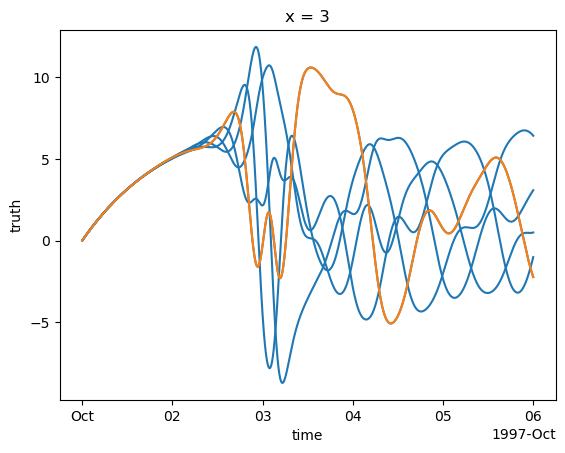

In [29]:
for i in range(5):
    ds_all['truth'].isel(x=i).plot(color="C0");
# ds_obs['truth'].plot(color="C1");
ds_all['truth'].isel(x=3).plot(color="C1");

In [30]:
output_arr = np.array(output_lst)

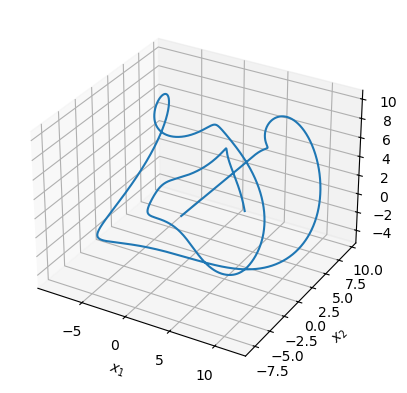

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(output_arr[:, 1],output_arr[:, 2], output_arr[:, 3])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()

## setup DA

This sets up all the require data assimilation information

In [32]:
def H(Z):
    """Function which takes the state vector Z and returns part of that state. Returned should be same shape as data provided"""
    if len(Z) == J:
        return Z[2] 
    else: 
        raise SyntaxWarning(f"Length of statevector should be {J} but is {len(Z)}")

In [33]:
ensemble.initialize_da_method(ensemble_method_name = "PF", 
                           hyper_parameters = {
                                               'like_sigma_weights' : 0.05,
                                               'like_sigma_state_vector' : 1.0,
                                               },
                           state_vector_variables = ["state"],
                           observation_path = ds_obs_dir,
                           observed_variable_name = "truth",
                           measurement_operator= H                           
                            )

# Run

In [34]:
ref_model = ensemble.ensemble_list[0].model

In [35]:
assimilation_window = 50

In [36]:
n_timesteps = int(round((ref_model.end_time - ref_model.start_time) /  ref_model.time_step,0))
time = []
lst_state_vector = []
lst_obj_prior = []
lst_obj_post = []
for i in tqdm(range(n_timesteps)):    
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    lst_obj_prior.append(ensemble.get_state_vector()[3])
    if i % assimilation_window == 0:  assimilate = True
    else:                             assimilate = False
    ensemble.update(assimilate)
    lst_obj_post.append(ensemble.get_state_vector()[3])
    lst_state_vector.append(ensemble.get_state_vector())
    # lst_Q.append(ensemble.get_value("state"))
    # TODO: adjust so that tLag ? currently still often 3

# end model - IMPORTANT! when working with dockers
ensemble.finalize()

100%|███████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:54<00:00, 16.97it/s]


UserWarning: /home/davidhaasnoot/eWaterCycle-WSL-WIP/lorenzlocal_33_20240417_0740/lorenz_config.json not found

In [ ]:
arr_prior = np.array(lst_obj_prior).T
arr_post = np.array(lst_obj_post).T
state_vector_arr = np.array(lst_state_vector)

### process the numpy data into easily acessed data types

In [ ]:
save, load = False, False
current_time = str(datetime.now())[:-10].replace(":","_")

### process states and parameters into xarrys

In [ ]:
if not load:    
    data_vars = {}
    for i, name in enumerate(range(J)):
        storage_terms_i = xr.DataArray(state_vector_arr[:,:,i].T,
                                       name=name,
                                       dims=["EnsembleMember","time"],
                                      coords=[np.arange(n_particles),time[:len(state_vector_arr)]],
                                      attrs={"title": f"Lorenz states over time for {n_particles} particles ", 
                                               "history": f"states of lorenz model: ewatercycle DA",
                                            "description":"Moddeled values",
                                                 "units": "mm"})
        data_vars[name] = storage_terms_i

    ds_combined = xr.Dataset(data_vars,
                             attrs={"title": f"Lorenz model over time for {n_particles} particles ", 
                                    "history": f"states of lorenz model: ewatercycle DA",}
                              )

In [ ]:
##### Save? 
if save:
    ds_combined.to_netcdf(output_path / f'combined_ds_{current_time}.nc')
    
if load:
    ds_combined = xr.open_dataset(glob.glob(str(output_path / 'combined_ds_*.nc'))[-1])

## Plotting

In [ ]:
save = True

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
x = 3
for i in range(n_particles):
    # ds_combined[7].isel(EnsembleMember=i).plot(ax=ax)
    plt.plot(list(output.index)[:len(ds_combined[x].isel(EnsembleMember=i).values)],ds_combined[x].isel(EnsembleMember=i),lw=0.5,color='C0',zorder=-1)
# for x in range(J):
ds_obs['truth'].plot(zorder=1,color="C1")
ax.set_title(f"Lorenz model with particle filter, assimilating every {assimilation_window} steps for {n_particles} ensemble members")
# if save: 
    # fig.savefig(figure_path / "lorenz_model.png",bbox_inches="tight",dpi=400)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
x = 4
for i in range(n_particles):
    # ds_combined[7].isel(EnsembleMember=i).plot(ax=ax)
    plt.plot(list(output.index)[:len(ds_combined[x].isel(EnsembleMember=i).values)],ds_combined[x].isel(EnsembleMember=i),lw=0.5,color='C0',zorder=-1)
# for x in range(J):
ds_obs['truth'].plot(zorder=1,color="C1")
ax.set_title(f"Lorenz model with particle filter, assimilating every {assimilation_window} steps for {n_particles} ensemble members")
if save: 
    fig.savefig(figure_path / "lorenz_model.png",bbox_inches="tight",dpi=400)